# ONLINE RETAIL II

####Business Problem :
1. Bagaimana memisakan pelaanggan untuk promosi yang tepat ?
    <p>Melakukan metode Clustering (Pengelompokkan) berdasarkan Recency, Frequency, Monetary ( RFM ). Model ini merupakan proses penilaian berdasarkan perilaku pelanggan yang akan dilihat dari waktu transaksi terakhir pelanggan (Recency), jumlah transaksi
(Frequency), dan uang yang dikeluarkan (Monetary). </p>

2. Bagaimana cara untuk meningkatkan volume penjualan pelanggan ?   

*   Membuat tabel cohort analytics berdasarkan kepuasan pelanggan untuk mengetahui tingkat pembelian pelanggan
*   mengetahui tingkat pembelian pelanggan
*   Membuat Market Basket Analytics (Menggabungkan barang) sehingga meningkatkan penjualan barang
*  Membuat Rekomendasi Produk

In [1]:
# upload files ke lembar kerja
from google.colab import files
files.upload()

Saving online_retail_II.csv to online_retail_II.csv


In [2]:
# import modul yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DATA UNDERSTANDING

In [3]:
# read data online retail
data = pd.read_csv('online_retail_II.csv', encoding='latin1')
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


#### Deskripsi singkat:
1.   InvoiceNo : Nomor faktur, jika nomor dimulai dengan huruf "c" artinya terjadi pembatalan transaksi.
2.   StockCode : Kode produk 
3. Description : Nama produk / item
4. Quantity : jumlah produk tiap transaksi
5. InvoiceDate : Tanggal dan waktu traksanksi.
6.  Price : Harga satuan / harga produk per unit.
7. Costumer ID : Nomor id pelanggan.
8. Country : Nama negara asal pelanggan.


In [4]:
# info tentang data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
# deskripsi data
data.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [6]:
# ukuran data
data.shape

(1067371, 8)

# DATA PREPARATION

### FORMATING DATA
Buat kolom baru yang berisi status dari transaksi (Invoice) yaitu Status_invoice, dimana jika dalam Invoice mengandung huruf C didalamnya maka status traksaksinya batal (Failed) dan juka Invoice tidak mengandung huruf C didalamnya maka transaksinya berstatus sukses (Sukses)

In [7]:
# buat kolom baru Status_invoice
data.loc[data['Invoice'].str.contains('C',na=False),'Status_invoice'] = 'Failed'
data.loc[~(data['Invoice'].str.contains('C',na=False)),'Status_invoice'] = 'Success'
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success


Cek apakah terdapat data duplikasi pada kolom StockCode, karena dalam setiap 1 jenis nama barang (Description) hanya memiliki 1 kode stok (StockCode). Apabila dalam satu kode barang (StockCode) terdapat lebih dari 1 nama barang yang tertera, maka hal tersebut mengindikasikan telah terjadi duplikasi.
<p>Oleh karena itu, dibuatlah kolom baru yang berisi deskripsi tentang apakah barang tersebut merupakan barang dupikasi atau tidak. jika barang tersebut adalah barang dupilkasi maka barang tersebut berstatus "Duplicate", jika tdak maka akan berstatus "Unduplicate".</p>

In [8]:
# cek unique pada StockCode dengan membuat dataframe baru yaitu data_StockCode
data_StockCode = data.groupby(['StockCode']).agg({'Description':'nunique'}).reset_index()
data_StockCode

,StockCode,Description
0,10002,1
1,10002R,1
2,10080,2
3,10109,1
4,10120,2
...,...,...
5300,gift_0001_60,0
5301,gift_0001_70,1
5302,gift_0001_80,1
5303,gift_0001_90,0


In [9]:
# buat kolom baru desc_stockcode
data_StockCode.loc[data_StockCode['Description'] > 1, 'desc_stockcode'] = 'Duplicated'
data_StockCode.loc[~(data_StockCode['Description'] > 1), 'desc_stockcode'] = 'Unduplicated'

In [10]:
# simpan data deskripsi tentang Kode Stok
data_StockCode.to_csv('data_StockCode.csv', index=False)

In [11]:
# Cek data_StockCode
data_StockCode.head(3)

,StockCode,Description,desc_stockcode
0,10002,1,Unduplicated
1,10002R,1,Unduplicated
2,10080,2,Duplicated


In [12]:
# buat array yang berisi data StockCode beserta deskripsinya yaitu desc_stockcode 
desc_stockcode = dict(zip(data_StockCode['StockCode'], data_StockCode['desc_stockcode']))


In [13]:
# buat kolom baru desc_stockcode kedalam data yang berisi deskripsi dari tiap StockCode 
data['desc_stockcode'] = data['StockCode'].map(desc_stockcode)

In [14]:
# recek data
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Success,Unduplicated
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Success,Duplicated


Buat kolom baru yaitu transaction_date yang hanya berisi data tahun, bulan dan tanggal transaksi.

In [15]:
# buat kolom tahun transaksi yaitu year
data['year'] = data['InvoiceDate'].str[:4]

# buat kolom bulan transaksi yaitu month
data['month'] = data['InvoiceDate'].str[5:7]

# buat kolom tanggal transaksi yaitu day
data['day'] = data['InvoiceDate'].str[8:10]


In [16]:
# buat kolom jam transaksi yaitu day
data['hour'] = data['InvoiceDate'].str[11:13]


In [17]:
# formating data waktu transaksi
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%Y-%m-%d %H:%M')

# waktu transaksi terakhir
max_date = max(data['InvoiceDate'])

# buat kolom baru yang berisi selisi waktu dalam transaksi
data['time_difference'] = max_date - data['InvoiceDate']

In [18]:
# cek data
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738 days 05:05:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738 days 05:05:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738 days 05:05:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738 days 05:05:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738 days 05:05:00


Buat kolom baru yaitu kolom penjualan (sales) yang berisi perkalian antara Price dan Quantity

In [19]:
# buat kolom baru sales
data['sales'] = data['Price'] * data['Quantity']

# tampilkan kolom sales
data['sales'].head(3)

0    83.4
1    81.0
2    81.0
Name: sales, dtype: float64

In [20]:
# ubah tipe data Costumer ID
data['Customer ID'] = data['Customer ID'].astype(str)

In [21]:
# ambil waktu transaksi terakhir dalam ukuran hari
data['time_difference'] = data['time_difference'].dt.days

In [22]:
# ubah type data time_difference ke integer
data['time_difference'] = data['time_difference'].astype(int)

In [23]:
# simpan data yang telah ditambahkan beberapa kolom
data.to_csv('Preparation_Online Retail.scv', index=False)

In [24]:
# cek ukuran data
data.shape

(1067371, 16)

In [25]:
# data Quantity yang bernilai negatif
data['Quantity'][data['Quantity']<0]

178       -12
179        -6
180        -4
181        -6
182       -12
           ..
1065910   -11
1067002    -1
1067176    -5
1067177    -1
1067178    -5
Name: Quantity, Length: 22950, dtype: int64

In [26]:
# data Quantity yang bernilai negatif
len(data['Quantity'][data['Quantity']<0])

22950

# DATA CLEANSING

In [27]:
# tampilkan data
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,30.0


In [28]:
# cek kolom yang memiliki missing value
data.isnull().sum()[data.isnull().sum()>=0]

Invoice               0
StockCode             0
Description        4382
Quantity              0
InvoiceDate           0
Price                 0
Customer ID           0
Country               0
Status_invoice        0
desc_stockcode        0
year                  0
month                 0
day                   0
hour                  0
time_difference       0
sales                 0
dtype: int64

In [29]:
# persentase kolom yang memiliki missing value
missing = round(100*((data.isnull().sum())/len(data)), 2)
missing

Invoice            0.00
StockCode          0.00
Description        0.41
Quantity           0.00
InvoiceDate        0.00
Price              0.00
Customer ID        0.00
Country            0.00
Status_invoice     0.00
desc_stockcode     0.00
year               0.00
month              0.00
day                0.00
hour               0.00
time_difference    0.00
sales              0.00
dtype: float64

In [30]:
# cek ukuran data
data.shape

(1067371, 16)

In [31]:
# Hapus data missing value
data = data.dropna()

In [32]:
# recek ukuran data
data.shape

(1062989, 16)

#VISUALISASI DATA

In [33]:
# tampilkan data
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0


In [34]:
# cek nama dari setiap kolom data
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Status_invoice', 'desc_stockcode',
       'year', 'month', 'day', 'hour', 'time_difference', 'sales'],
      dtype='object')

###Invoice

In [35]:
# total transaksi
print('Total transaksi : ', len(data['Invoice']))

Total transaksi :  1062989


In [36]:
# banyaknya transaksi yang sukses dan gagal pada tahun 2009 - 2011
data['Invoice'].groupby(data['Status_invoice']).agg('count').sort_values(ascending = False).head(5)

Status_invoice
Success    1043495
Failed       19494
Name: Invoice, dtype: int64

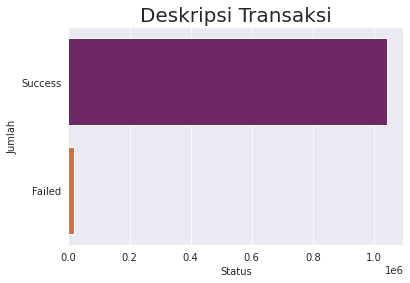

In [37]:
# plot banyaknya transaksi yang sukses dan gagal
a = data['Invoice'].groupby(data['Status_invoice']).agg('count').sort_values(ascending = False)
sns.barplot(x = a.values, y = a.index, palette = 'inferno')
plt.title('Deskripsi Transaksi', fontsize = 20)
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.show()

Banyaknya transaksi yang sukse sebanyak 805620 dan transaksi yang gagal sebanyak 18744

### StocCode

In [38]:
# banyak kode barang
print('Banyak kode barang : ',len(data['StockCode'].unique()))

Banyak kode barang :  4950


In [39]:
# 5 kode barang dengan frekuensi transaksi terbesar
data['StockCode'].value_counts().head(5)

85123A    5829
22423     4423
85099B    4216
21212     3318
20725     3259
Name: StockCode, dtype: int64

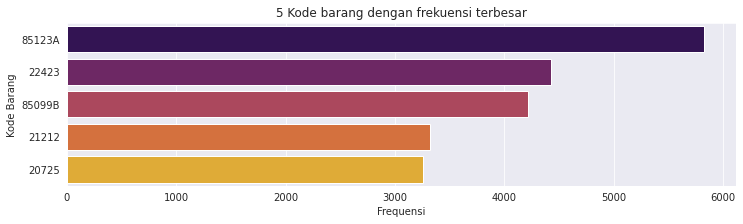

In [40]:
# cek plot 5 kode barang dengan frekuensi transaksi terbesar
plt.rcParams['figure.figsize']=(12, 3)
code = data['StockCode'].value_counts().head(5)
sns.barplot(x=code.values, y=code.index, palette = 'inferno')
plt.title('5 Kode barang dengan frekuensi terbesar')
plt.ylabel('Kode Barang')
plt.xlabel('Frequensi')
plt.show()

In [41]:
# 5 kode barang dengan frekuensi transaksi terkecil
data['StockCode'].value_counts().tail(5)

37477C     1
85231e     1
21036      1
47503J     1
37484      1
Name: StockCode, dtype: int64

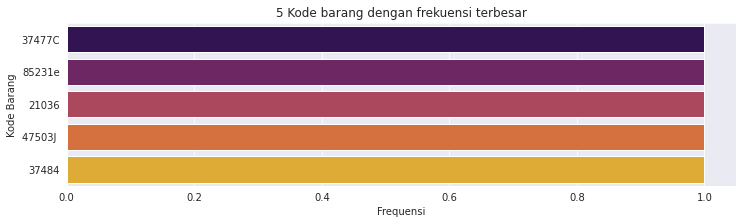

In [42]:
# cek plot 5 kode barang dengan frekuensi transaksi tekecil
plt.rcParams['figure.figsize']=(12, 3)
code = data['StockCode'].value_counts().tail(5)
sns.barplot(x=code.values, y=code.index, palette = 'inferno')
plt.title('5 Kode barang dengan frekuensi terbesar')
plt.ylabel('Kode Barang')
plt.xlabel('Frequensi')
plt.show()

Dapat dilihat bahwa Kode barang (StockCode) dengan frekuensi terbesar yaitu barang dengan kode 85123A dengan frekuensi sebesar 5322 dan kode barang dengan frekuensi terkecil yaitu barang dengan kode 35974, 21053, 35822P, 90025B dan 90011C dengan frekuensi yang sama sebesar 1.

In [43]:
# 5 trnsaksi dengan kode barang tertentu dengan kuantitas terbesar
data['Quantity'].groupby(data['StockCode']).agg('sum').sort_values(ascending = False).head(5)

StockCode
84077     108545
85123A     96066
85099B     95739
21212      95450
22197      89125
Name: Quantity, dtype: int64

In [44]:
# 5 barang dengan kode tertentu dengan kuantitas terkecil
data['Quantity'].groupby(data['StockCode']).agg('sum').sort_values(ascending = False).tail(5)

StockCode
10120    -8350
23003    -8516
22126   -10000
23005   -14418
20852   -18800
Name: Quantity, dtype: int64

### Quantity

In [45]:
# jumlah transaksi barang dengan status sukses dan gagal
data['Quantity'].groupby(data['Status_invoice']).agg('sum').sort_values(ascending = False)

Status_invoice
Success    11175127
Failed      -490992
Name: Quantity, dtype: int64

In [46]:
# 5 negara yang melakukan transaksi dengan kuantitas terbesar
data['Quantity'].groupby(data['Country']).agg('sum').sort_values(ascending = False).head(5)

Country
United Kingdom    8768518
Netherlands        381951
EIRE               331341
Denmark            235218
Germany            224581
Name: Quantity, dtype: int64

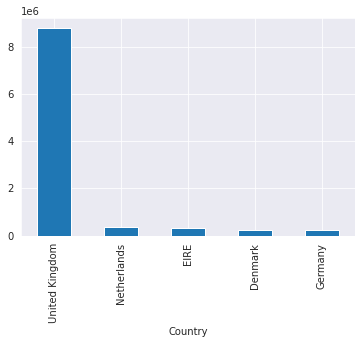

In [47]:
# 5 negara yang melakukan transaksi dengan kuantitas terbesar
data['Quantity'].groupby(data['Country']).agg('sum').sort_values(ascending = False).head(5).plot.bar(figsize = (6, 4))

In [48]:
# 5 negara yang melakukan transaksi dengan kuantitas terkecil
data['Quantity'].groupby(data['Country']).agg('sum').sort_values(ascending = False).tail(5)

Country
European Community    497
Lebanon               457
West Indies           395
Saudi Arabia           75
Nigeria                56
Name: Quantity, dtype: int64

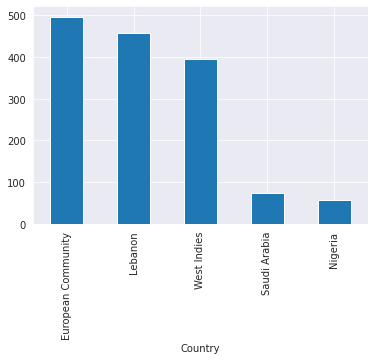

In [49]:
# 5 negara yang melakukan transaksi dengan kuantitas terkecil
data['Quantity'].groupby(data['Country']).agg('sum').sort_values(ascending = False).tail(5).plot.bar(figsize = (6, 4))

Dapat dilihat bahwa negara yang melakukan transaksi dengan kuantitas terbesar yaitu negara United Kingdon dengan kuantitas sebesar 8353502 dan yang terkecil adalah negara Saidi Arabia dengan kuantitas sebesar 75.

In [50]:
# jumlah transaksi yang dilakukan pada tahun 2009-2011
data['Quantity'].groupby(data['year']).agg('sum').sort_values(ascending = False)

year
2010    5426034
2011    4846735
2009     411366
Name: Quantity, dtype: int64

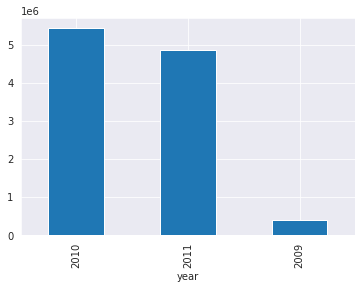

In [51]:
# kuantitas transaksi yang dilakukan pada tahun 2009-2011
data['Quantity'].groupby(data['year']).agg('sum').sort_values(ascending = False).plot.bar(figsize = (6, 4))

Dapat dilihat bahwa kuantitas transaksi yang dilakukan mulai tahun 2009 - 2011 mengalami pemingkatan, terutama pada tahun 2009 dan 2010 

### Price

In [52]:
# tampilkan data
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0


In [53]:
# deskripsi kolom price
data['Price'].describe()

count    1.062989e+06
mean     4.668554e+00
std      1.238071e+02
min     -5.359436e+04
25%      1.250000e+00
50%      2.100000e+00
75%      4.150000e+00
max      3.897000e+04
Name: Price, dtype: float64

In [54]:
# 5 kode barang dengan harga tertinggi
data['Price'].groupby(data['StockCode']).agg('sum').sort_values(ascending = False).head(5)


StockCode
M            751391.10
AMAZONFEE    328781.84
DOT          322667.49
POST          69226.69
22423         61747.01
Name: Price, dtype: float64

In [55]:
# 5 kode barang dengan harga terendah
data['Price'].groupby(data['StockCode']).agg('sum').sort_values(ascending = False).tail(5)

StockCode
84641          0.00
35600A         0.00
35605A         0.00
35978          0.00
B        -147614.08
Name: Price, dtype: float64

Dapat dilihat bahwa kode barang yang memiliki harga tertinggi yaitu barang dengan kode M dan dengan harga 476376.17, sedangkan kode barang dengan harga terendah yaitu barang dengan kode 17061 dengan harga 0.4

### CostumerID

In [56]:
# frekuensi dari berbagai Costumer ID dalam melakukan transaksi
frequency=data['Invoice'].groupby(data['Customer ID']).agg('count')
frequency = frequency.reset_index()
frequency.columns = ['Customer ID', 'Frequency']
frequency

,Customer ID,Frequency
0,12346.0,48
1,12347.0,253
2,12348.0,51
3,12349.0,180
4,12350.0,17
...,...,...
5938,18284.0,29
5939,18285.0,12
5940,18286.0,70
5941,18287.0,156


In [57]:
# 5 frekuensi terbesar dari berbagai Costumer ID dalam melakukan transaksi
frequency=data['Invoice'].groupby(data['Customer ID']).agg('count').sort_values(ascending = False)
frequency = frequency.reset_index()
frequency.columns = ['Customer ID', 'Frequency']
frequency.head(5)

,Customer ID,Frequency
0,nan,238625
1,17841.0,13097
2,14911.0,11613
3,12748.0,7307
4,14606.0,6709


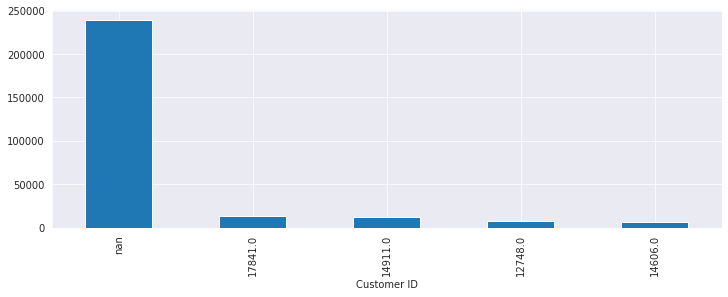

In [58]:
# plot 5 frekuensi terbesar dari berbagai Costumer ID dalam melakukan transaksi
data['Invoice'].groupby(data['Customer ID']).agg('count').sort_values(ascending = False).head(5).plot.bar(figsize=(12, 4))

In [59]:
# 5 frekuensi terkecil dari berbagai Costumer ID dalam melakukan transaksi
frequency=data['Invoice'].groupby(data['Customer ID']).agg('count').sort_values(ascending = False)
frequency = frequency.reset_index()
frequency.columns = ['Customer ID', 'Frequency']
frequency.tail(5)

,Customer ID,Frequency
5938,17291.0,1
5939,14144.0,1
5940,15040.0,1
5941,13100.0,1
5942,14190.0,1


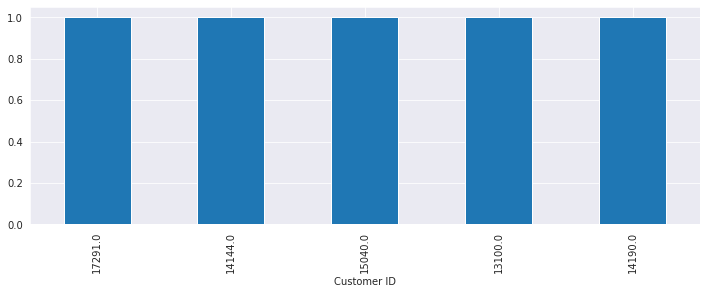

In [60]:
# plot 5 frekuensi terkecil dari berbagai Costumer ID dalam melakukan transaksi
data['Invoice'].groupby(data['Customer ID']).agg('count').sort_values(ascending = False).tail(5).plot.bar(figsize=(12, 4))

Dapat dilihat bahwa Costumer ID yang memiliki frekuensi transaksi terbanyak yaitu costumer dengan nomor id 17841 dengan transaksi sebanayak 13097 dan terdapat 5 costumer yang memiliki frekuensi transaksi terkecil yaitu 13205.0, 13215.0, 15893.0, 13222.0, 15316.0 dengan transaksi sebanayak 1 kali.

In [61]:
# total pengeluaran dari setiap costumer dalam melakukan transaksi
amount=data['sales'].groupby(data['Customer ID']).agg('sum')
amount = amount.reset_index()
amount.columns = ['Customer ID', 'Total pengeluaran']
amount

,Customer ID,Total pengeluaran
0,12346.0,-6.468000e+01
1,12347.0,5.633320e+03
2,12348.0,2.019400e+03
3,12349.0,4.404540e+03
4,12350.0,3.344000e+02
...,...,...
5938,18284.0,4.366800e+02
5939,18285.0,4.270000e+02
5940,18286.0,1.188430e+03
5941,18287.0,4.177890e+03


In [62]:
# 5 costumer yang melakukan transaksi dengan nilai pengeluaran terbesar
amount=data['sales'].groupby(data['Customer ID']).agg('sum').sort_values(ascending = False)
amount = amount.reset_index()
amount.columns = ['Customer ID', 'Total pengeluaran']
amount.head(5)

,Customer ID,Total pengeluaran
0,nan,2.638958e+06
1,18102.0,5.982152e+05
2,14646.0,5.233421e+05
3,14156.0,2.965647e+05
4,14911.0,2.702485e+05


In [63]:
# 5 costumer yang melakukan transaksi dengan nilai pengeluaran terbesar
amount=data['sales'].groupby(data['Customer ID']).agg('sum').sort_values(ascending = False)
amount = amount.reset_index()
amount.columns = ['Customer ID', 'Total pengeluaran']
amount.tail(5)

,Customer ID,Total pengeluaran
5938,16981.0,-4620.86
5939,15760.0,-5795.87
5940,15849.0,-5876.34
5941,12918.0,-10953.50
5942,17399.0,-25111.09


In [64]:
# 5 costumer yang melakukan transaksi dengan nilai pengeluaran terbesar
time=delta=data['time_difference'].groupby(data['Customer ID']).agg('min')
time = time.reset_index()
time.columns = ['Customer ID', 'Waktu Terakhir Transaksi']
time

,Customer ID,Waktu Terakhir Transaksi
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
5938,18284.0,429
5939,18285.0,660
5940,18286.0,476
5941,18287.0,42


In [65]:
# 5 costumer yang melakukan transaksi terakhir paling lama
time=delta=data['time_difference'].groupby(data['Customer ID']).agg('min').sort_values(ascending = False)
time = time.reset_index()
time.columns = ['Customer ID', 'Waktu Terakhir Transaksi']
time.head(5)

,Customer ID,Waktu Terakhir Transaksi
0,17592.0,738
1,12636.0,738
2,17641.0,738
3,15833.0,737
4,13526.0,737


In [66]:
# 5 costumer yang melakukan transaksi terakhir baru saja 
time=delta=data['time_difference'].groupby(data['Customer ID']).agg('min').sort_values(ascending = False)
time = time.reset_index()
time.columns = ['Customer ID', 'Waktu Terakhir Transaksi']
time.tail(5)

,Customer ID,Waktu Terakhir Transaksi
5938,17315.0,0
5939,14796.0,0
5940,12662.0,0
5941,17243.0,0
5942,nan,0


### Country

In [67]:
# Frekuensi tiap negara melakukan transaksi
frequency=data['Invoice'].groupby(data['Country']).agg('count')
frequency = frequency.reset_index()
frequency.columns = ['Country', 'Frequency']
frequency

,Country,Frequency
0,Australia,1913
1,Austria,938
2,Bahrain,126
3,Belgium,3123
4,Bermuda,34
5,Brazil,94
6,Canada,228
7,Channel Islands,1664
8,Cyprus,1176
9,Czech Republic,30


In [68]:
# 5 Negara yang melakukan transaksi terbanyak
frequency=data['Invoice'].groupby(data['Country']).agg('count').sort_values(ascending = False)
frequency = frequency.reset_index()
frequency.columns = ['Country', 'Frequency']
frequency.head(5)

,Country,Frequency
0,United Kingdom,976948
1,EIRE,17866
2,Germany,17624
3,France,14330
4,Netherlands,5140


In [69]:
# 5 Negara yang melakukan transaksi terkecil
frequency=data['Invoice'].groupby(data['Country']).agg('count').sort_values(ascending = False)
frequency = frequency.reset_index()
frequency.columns = ['Country', 'Frequency']
frequency.tail(5)

,Country,Frequency
38,West Indies,54
39,Bermuda,34
40,Nigeria,32
41,Czech Republic,30
42,Saudi Arabia,10


In [70]:
# pengeluaran tiap negara dalam melakukan transaksi
amount=data['sales'].groupby(data['Country']).agg('count')
amount = amount.reset_index()
amount.columns = ['Country', 'Total Pengeluaran']
amount

,Country,Total Pengeluaran
0,Australia,1913
1,Austria,938
2,Bahrain,126
3,Belgium,3123
4,Bermuda,34
5,Brazil,94
6,Canada,228
7,Channel Islands,1664
8,Cyprus,1176
9,Czech Republic,30


In [71]:
# 5 Negara dengan transaksi total pengeluaran terbesar
amount=data['sales'].groupby(data['Country']).agg('count').sort_values(ascending = False)
amount = amount.reset_index()
amount.columns = ['Country', 'Total Pengeluaran']
amount.head(5)

,Country,Total Pengeluaran
0,United Kingdom,976948
1,EIRE,17866
2,Germany,17624
3,France,14330
4,Netherlands,5140


In [72]:
# 5 Negara dengan transaksi total pengeluaran terkecil
amount=data['sales'].groupby(data['Country']).agg('count').sort_values(ascending = False)
amount = amount.reset_index()
amount.columns = ['Country', 'Total Pengeluaran']
amount.tail(5)

,Country,Total Pengeluaran
38,West Indies,54
39,Bermuda,34
40,Nigeria,32
41,Czech Republic,30
42,Saudi Arabia,10


In [73]:
# Daftar waktu terakhir transaksi setiap negara
time=data['time_difference'].groupby(data['Country']).agg('min')
time = time.reset_index()
time.columns = ['Country', 'Waktu Terakhir Transaksi']
time

,Country,Waktu Terakhir Transaksi
0,Australia,15
1,Austria,1
2,Bahrain,203
3,Belgium,0
4,Bermuda,631
5,Brazil,238
6,Canada,106
7,Channel Islands,1
8,Cyprus,7
9,Czech Republic,20


In [74]:
# 5 Negara dengan waktu transaksi teraksi terlama
time=data['time_difference'].groupby(data['Country']).agg('min').sort_values(ascending = False)
time = time.reset_index()
time.columns = ['Country', 'Waktu Terakhir Transaksi']
time.head(5)

,Country,Waktu Terakhir Transaksi
0,Bermuda,631
1,Thailand,522
2,Nigeria,475
3,West Indies,473
4,Korea,375


In [75]:
# 5 Negara dengan waktu transaksi teraksi terbaru (tercepat)
time=data['time_difference'].groupby(data['Country']).agg('min').sort_values(ascending = False)
time = time.reset_index()
time.columns = ['Country', 'Waktu Terakhir Transaksi']
time.tail(5)

,Country,Waktu Terakhir Transaksi
38,France,0
39,Norway,0
40,Belgium,0
41,United Kingdom,0
42,EIRE,0


### Status_invoice

In [76]:
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0


In [77]:
# jumlah ttransaksi yang berstatus sukses dan gagal
frequency=data['Status_invoice'].value_counts().reset_index()
frequency.columns=['Status', 'Frequency']
frequency

,Status,Frequency
0,Success,1043495
1,Failed,19494


In [78]:
# daftar tiat transaksi yang berasal dari berbagai negara yang berstatus 
status = data['Status_invoice'].groupby(data['Country']).agg('value_counts').unstack().reset_index()
status

Status_invoice,Country,Failed,Success
0,Australia,98.0,1815.0
1,Austria,16.0,922.0
2,Bahrain,2.0,124.0
3,Belgium,54.0,3069.0
4,Bermuda,NaN,34.0
5,Brazil,NaN,94.0
6,Canada,NaN,228.0
7,Channel Islands,95.0,1569.0
8,Cyprus,21.0,1155.0
9,Czech Republic,5.0,25.0


### desc_Stockcode

In [79]:
# tampilkan data
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0


In [80]:
# jumlah karakter desc_stockcode yang berstatus duplikat dan tidak duplikat
(data['desc_stockcode']).value_counts()


Unduplicated    638820
Duplicated      424169
Name: desc_stockcode, dtype: int64

In [81]:
# list jumlah tiap StockCode yang berstatus Duplicate dan UndupliCate
Code = data['desc_stockcode'].groupby(data['StockCode']).agg('value_counts').unstack()
Code

desc_stockcode,Duplicated,Unduplicated
StockCode,,
10002,NaN,398.0
10002R,NaN,3.0
10080,29.0,NaN
10109,NaN,1.0
10120,79.0,NaN
...,...,...
gift_0001_40,NaN,5.0
gift_0001_50,NaN,6.0
gift_0001_70,NaN,1.0


### year

In [82]:
# data jumlah transaksi tiap tahun
data['year'].agg('value_counts')

2010    519889
2011    498100
2009     45000
Name: year, dtype: int64

In [83]:
# data transaksi yang berstatus sukses dan gagal tiap tahunya
data['year'].groupby(data['Status_invoice']).agg('value_counts').unstack()

year,2009,2010,2011
Status_invoice,,,
Failed,1015,9919,8560
Success,43985,509970,489540


In [84]:
# data jumalh transaksi tiap negara ditiap tahunya
frequency = data['year'].groupby(data['Country']).agg('value_counts').unstack()
frequency = frequency.reset_index()
frequency.columns = ['Country', '2009', '2010', '2011']
frequency

,Country,2009,2010,2011
0,Australia,27.0,662.0,1224.0
1,Austria,38.0,508.0,392.0
2,Bahrain,NaN,108.0,18.0
3,Belgium,20.0,1129.0,1974.0
4,Bermuda,NaN,34.0,NaN
5,Brazil,NaN,62.0,32.0
6,Canada,NaN,77.0,151.0
7,Channel Islands,43.0,880.0,741.0
8,Cyprus,196.0,441.0,539.0
9,Czech Republic,NaN,NaN,30.0


In [85]:
# total barang / total kuantitas barang dalam transaksi tahun 2009 - 2011 
print('Total barang yang terjual dari tahun 2009 - 20011 yaitu : ', data['Quantity'].sum())
print('\njumlah barang(kuantitas) yang terjual tiap tahunya')

# jumlah barang(kuantitas) yang terjual tiap tahunya
quantity = data['Quantity'].groupby(data['year']).sum()
quantity

Total barang yang terjual dari tahun 2009 - 20011 yaitu :  10684135

jumlah barang(kuantitas) yang terjual tiap tahunya


year
2009     411366
2010    5426034
2011    4846735
Name: Quantity, dtype: int64

In [86]:
# total seluruh biaya transaksi pada tahun 2009-2011
data['sales'].groupby(data['year']).agg('sum')

year
2009    7.998471e+05
2010    9.488595e+06
2011    8.998809e+06
Name: sales, dtype: float64

### month

In [87]:
# banyaknya transakasi yang terjadi tiap bulanya
frequency=data['Invoice'].groupby(data['month']).agg('count')
frequency = frequency.reset_index()
frequency.columns = ['Month', 'Frequency']
frequency

,Month,Frequency
0,01,66366
1,02,56520
2,03,77842
3,04,63637
4,05,71739
5,06,76591
6,07,72661
7,08,68349
8,09,92083
9,10,119579


In [88]:
# daftar frekuensi costumerID melakukan transakasi yang di tiap bulanya
data['month'].groupby(data['Customer ID']).agg('value_counts').unstack().head(5)


month,01,02,03,04,05,06,07,08,09,10,11,12
Customer ID,,,,,,,,,,,,
12346.0,7.0,NaN,5.0,NaN,NaN,29.0,NaN,NaN,NaN,2.0,NaN,5.0
12347.0,29.0,NaN,NaN,24.0,NaN,18.0,NaN,22.0,NaN,87.0,NaN,73.0
12348.0,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,23.0,NaN,NaN,17.0
12349.0,NaN,NaN,NaN,46.0,1.0,NaN,NaN,NaN,NaN,55.0,73.0,5.0
12350.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# jumlah transaksi dari tiap negara yang terjadi pada tiap bulanya
data['Country'].groupby(data['month']).agg('value_counts').unstack()

Country,Australia,Austria,Bahrain,Belgium,Bermuda,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Hong Kong,Iceland,Israel,Italy,Japan,Korea,Lebanon,Lithuania,Malta,Netherlands,Nigeria,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified,West Indies
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01,127.0,NaN,1.0,157.0,NaN,NaN,NaN,60.0,20.0,NaN,40.0,769.0,NaN,46.0,1011.0,1441.0,133.0,57.0,29.0,14.0,115.0,5.0,NaN,45.0,NaN,NaN,380.0,1.0,NaN,25.0,124.0,NaN,NaN,56.0,517.0,56.0,160.0,NaN,105.0,NaN,60807.0,65.0,NaN
02,123.0,77.0,29.0,184.0,NaN,NaN,NaN,10.0,206.0,15.0,52.0,962.0,NaN,12.0,829.0,833.0,NaN,NaN,NaN,16.0,14.0,134.0,NaN,NaN,NaN,47.0,292.0,NaN,32.0,28.0,85.0,65.0,9.0,NaN,129.0,96.0,123.0,NaN,NaN,171.0,51947.0,NaN,NaN
03,129.0,54.0,16.0,210.0,34.0,NaN,10.0,199.0,119.0,NaN,44.0,1304.0,NaN,216.0,949.0,1224.0,46.0,2.0,NaN,NaN,130.0,32.0,NaN,NaN,NaN,NaN,377.0,NaN,38.0,27.0,216.0,NaN,1.0,NaN,299.0,111.0,116.0,NaN,NaN,67.0,71872.0,NaN,NaN
04,37.0,62.0,NaN,240.0,NaN,32.0,NaN,60.0,53.0,2.0,10.0,941.0,11.0,114.0,486.0,1251.0,47.0,80.0,24.0,6.0,87.0,56.0,NaN,NaN,NaN,NaN,207.0,NaN,NaN,25.0,83.0,NaN,NaN,98.0,133.0,176.0,159.0,NaN,22.0,1.0,59104.0,30.0,NaN
05,179.0,86.0,44.0,156.0,NaN,NaN,1.0,254.0,18.0,NaN,19.0,1433.0,NaN,55.0,1160.0,1170.0,53.0,95.0,NaN,NaN,186.0,12.0,NaN,NaN,NaN,NaN,497.0,NaN,NaN,69.0,119.0,NaN,NaN,NaN,178.0,50.0,397.0,NaN,15.0,NaN,65435.0,58.0,NaN
06,282.0,20.0,15.0,369.0,NaN,NaN,57.0,90.0,67.0,NaN,195.0,1321.0,21.0,41.0,1055.0,1305.0,9.0,40.0,18.0,NaN,29.0,48.0,NaN,NaN,NaN,47.0,542.0,NaN,166.0,45.0,205.0,NaN,NaN,NaN,207.0,74.0,244.0,10.0,36.0,NaN,70024.0,9.0,NaN
07,237.0,55.0,NaN,233.0,NaN,NaN,78.0,5.0,NaN,NaN,21.0,1412.0,29.0,108.0,814.0,1653.0,25.0,NaN,NaN,70.0,6.0,92.0,NaN,NaN,78.0,NaN,189.0,NaN,49.0,58.0,105.0,NaN,NaN,75.0,252.0,116.0,213.0,66.0,26.0,NaN,66306.0,290.0,NaN
08,114.0,150.0,NaN,275.0,NaN,NaN,5.0,191.0,NaN,NaN,93.0,1392.0,NaN,62.0,794.0,1256.0,33.0,51.0,22.0,171.0,101.0,9.0,NaN,NaN,NaN,182.0,548.0,29.0,90.0,39.0,67.0,NaN,NaN,NaN,315.0,194.0,359.0,NaN,NaN,75.0,61655.0,23.0,54.0
09,125.0,108.0,NaN,252.0,NaN,62.0,NaN,267.0,111.0,NaN,86.0,2226.0,NaN,91.0,1669.0,1536.0,8.0,2.0,NaN,27.0,63.0,20.0,10.0,12.0,NaN,NaN,647.0,NaN,255.0,54.0,238.0,NaN,NaN,81.0,411.0,72.0,283.0,NaN,4.0,65.0,83121.0,177.0,NaN


In [90]:
# jumlah transaksi yang berstaus sukses dan gagal ditiap bulanya
frequency = data['Status_invoice'].groupby(data['month']).agg('value_counts').unstack()
frequency = frequency.reset_index()
frequency.columns = ['Month', 'Failed', 'Succes']
frequency


,Month,Failed,Succes
0,01,1387,64979
1,02,1051,55469
2,03,1543,76299
3,04,1185,62452
4,05,1604,70135
5,06,1504,75087
6,07,1419,71242
7,08,1241,67108
8,09,1617,90466
9,10,2241,117338


In [91]:
# total biaya transaksi yang terjadi tiap bulanya
Amount=data['sales'].groupby(data['month']).agg('sum')
Amount = Amount.reset_index()
Amount.columns = ['Month', 'Amount']
Amount

,Month,Amount
0,01,1.184033e+06
1,02,1.031154e+06
2,03,1.449116e+06
3,04,1.083788e+06
4,05,1.338656e+06
5,06,1.370910e+06
6,07,1.256536e+06
7,08,1.339457e+06
8,09,1.873338e+06
9,10,2.115873e+06


### day

In [92]:
# jumlah transaksi yang berstaus sukses dan gagal ditiap bulanya
frequency = data['Status_invoice'].groupby(data['day']).agg('value_counts').unstack()
frequency = frequency.reset_index()
frequency.columns = ['day', 'Failed', 'Succes']
frequency

,day,Failed,Succes
0,01,701,36370
1,02,583,32277
2,03,535,30932
3,04,554,36377
4,05,693,38093
5,06,810,39397
6,07,786,46428
7,08,942,44808
8,09,688,35537
9,10,824,35686


In [93]:
amount = data['sales'].groupby(data['day']).agg('sum')
amount = amount.reset_index()
amount.columns = ['Day', 'Amount']
amount

,Day,Amount
0,01,666175.531
1,02,594235.080
2,03,650019.431
3,04,676253.740
4,05,647576.540
5,06,660240.320
6,07,904472.080
7,08,849022.401
8,09,696988.730
9,10,647836.440


# SOLULUSI 1: Menggunakan Metode K-Means
Melakukan clustering dengan melihat waktu terakhir transaksi, frekuensi dan uang yang dikeluarkan saat transaksi terjadi.

### Analisis costumer
Analisis kontumer akan didasarkan pada :
1. R (Recency): Waktu terakhir melakukan transaksi
2. F (Frequency) : Banyaknya jumlah transaksi yang dilakukan
3. M (Monetary) : Total biaya transaksi

#### CostumerID

In [94]:
# tampilkan data
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0


In [95]:
# frekuensi dari berbagai Costumer ID dalam melakukan transaksi
frequency=data['Invoice'].groupby(data['Customer ID']).agg('count')
frequency = frequency.reset_index()
frequency.columns = ['Customer ID', 'Frequency']
frequency.head()

,Customer ID,Frequency
0,12346.0,48
1,12347.0,253
2,12348.0,51
3,12349.0,180
4,12350.0,17


In [96]:
# waktu terakhir transaksi dari berbagai Costumer ID 
time = data['time_difference'].groupby(data['Customer ID']).agg('min')
time = time.reset_index()
time.columns = ['Customer ID', 'Last Time']
time.head()

,Customer ID,Last Time
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [97]:
# total biaya transaksi dari berbagai Costumer ID 
amount = data['sales'].groupby(data['Customer ID']).agg('sum')
amount = amount.reset_index()
amount.columns = ['Customer ID', 'Total Amount']
amount.head()

,Customer ID,Total Amount
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [98]:
# gabungkan tabel  amount dan frequency
costumer = pd.merge(amount, frequency, on='Customer ID', how='inner')
costumer

,Customer ID,Total Amount,Frequency
0,12346.0,-6.468000e+01,48
1,12347.0,5.633320e+03,253
2,12348.0,2.019400e+03,51
3,12349.0,4.404540e+03,180
4,12350.0,3.344000e+02,17
...,...,...,...
5938,18284.0,4.366800e+02,29
5939,18285.0,4.270000e+02,12
5940,18286.0,1.188430e+03,70
5941,18287.0,4.177890e+03,156


In [99]:
# gabungkan tabel  costumer dan time
costumer = pd.merge(costumer, time, on='Customer ID', how='inner')
costumer

,Customer ID,Total Amount,Frequency,Last Time
0,12346.0,-6.468000e+01,48,325
1,12347.0,5.633320e+03,253,1
2,12348.0,2.019400e+03,51,74
3,12349.0,4.404540e+03,180,18
4,12350.0,3.344000e+02,17,309
...,...,...,...,...
5938,18284.0,4.366800e+02,29,429
5939,18285.0,4.270000e+02,12,660
5940,18286.0,1.188430e+03,70,476
5941,18287.0,4.177890e+03,156,42


### Analisis Country
Analisis kontumer akan didasarkan pada :
1. R (Recency): Waktu terakhir melakukan transaksi
2. F (Frequency) : Banyaknya jumlah transaksi yang dilakukan
3. M (Monetary) : Total biaya transaksi

In [100]:
# frekuensi dari berbagai Negara dalam melakukan transaksi
frequency=data['Invoice'].groupby(data['Country']).agg('count')
frequency = frequency.reset_index()
frequency.columns = ['Country', 'Frequency']
frequency.head()

,Country,Frequency
0,Australia,1913
1,Austria,938
2,Bahrain,126
3,Belgium,3123
4,Bermuda,34


In [101]:
# waktu terakhir transaksi dari berbagai Negara 
time = data['time_difference'].groupby(data['Country']).agg('min')
time = time.reset_index()
time.columns = ['Country', 'Last Time']
time.head()

,Country,Last Time
0,Australia,15
1,Austria,1
2,Bahrain,203
3,Belgium,0
4,Bermuda,631


In [102]:
# total biaya transaksi dari berbagai Costumer ID 
amount = data['sales'].groupby(data['Country']).agg('sum')
amount = amount.reset_index()
amount.columns = ['Country', 'Total Amount']
amount.head()

,Country,Total Amount
0,Australia,167129.07
1,Austria,23177.60
2,Bahrain,2861.55
3,Belgium,63574.49
4,Bermuda,1253.14


In [103]:
# gabungkan tabel frequency dan time
country = pd.merge(frequency, time, on='Country', how='inner')
country

,Country,Frequency,Last Time
0,Australia,1913,15
1,Austria,938,1
2,Bahrain,126,203
3,Belgium,3123,0
4,Bermuda,34,631
5,Brazil,94,238
6,Canada,228,106
7,Channel Islands,1664,1
8,Cyprus,1176,7
9,Czech Republic,30,20


In [104]:
# gabungkan tabel costumer dan amount
country = pd.merge(country, amount, on='Country', how='inner')
country

,Country,Frequency,Last Time,Total Amount
0,Australia,1913,15,1.671291e+05
1,Austria,938,1,2.317760e+04
2,Bahrain,126,203,2.861550e+03
3,Belgium,3123,0,6.357449e+04
4,Bermuda,34,631,1.253140e+03
5,Brazil,94,238,1.411870e+03
6,Canada,228,106,4.883040e+03
7,Channel Islands,1664,1,4.145361e+04
8,Cyprus,1176,7,2.416274e+04
9,Czech Republic,30,20,7.077200e+02


## OUTLIER 
lihat outlier dari dataframe costumer dan country, mengecek outlier data dengan melihat boxplot.

### costumer

In [105]:
# cek nama kolom costumer
costumer.columns

Index(['Customer ID', 'Total Amount', 'Frequency', 'Last Time'], dtype='object')

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fc247690>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fc24a650>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fc252690>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fc252150>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fc247b90>,
  <matplotlib.lines.Line2D at 0x7fe4fc24a110>]}

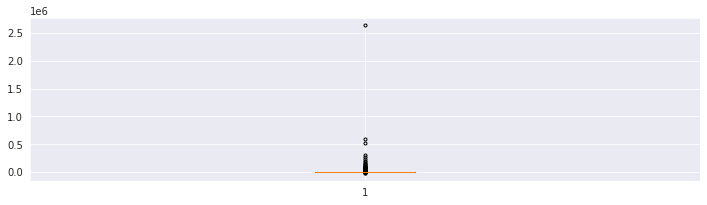

In [106]:
#  boxplot Total Amount untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(costumer["Total Amount"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fc22b250>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fc2320d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fc239110>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fc232b50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fc22b5d0>,
  <matplotlib.lines.Line2D at 0x7fe4fc22bb50>]}

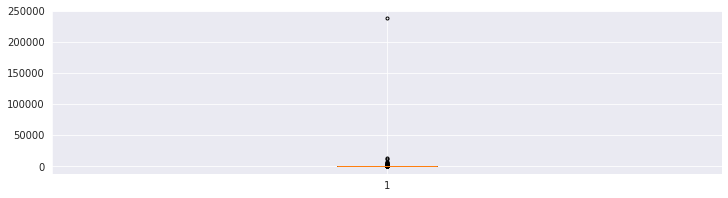

In [107]:
#  boxplot Total Amount untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(costumer["Frequency"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fc49c990>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fc423750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fc4c5310>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fc4a3350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fc3aa5d0>,
  <matplotlib.lines.Line2D at 0x7fe4fc414410>]}

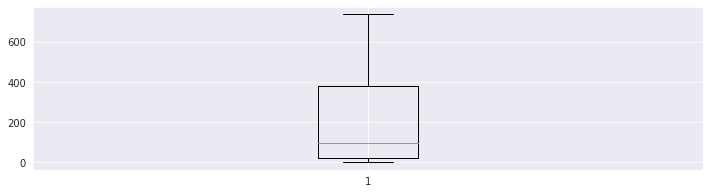

In [108]:
#  boxplot Total Amount untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(costumer["Last Time"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

### country

In [109]:
# cek nama kolom country
country.columns

Index(['Country', 'Frequency', 'Last Time', 'Total Amount'], dtype='object')

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fc27e850>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fc441a50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fc4b0050>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fc445510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fc27ef50>,
  <matplotlib.lines.Line2D at 0x7fe4fc32db50>]}

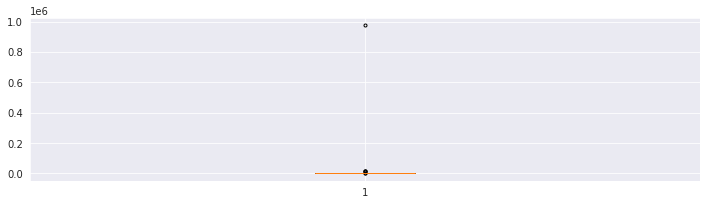

In [110]:
#  boxplot Total Frequency untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(country["Frequency"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fcb49dd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fca8db50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fcb766d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fcb76b90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fcb495d0>,
  <matplotlib.lines.Line2D at 0x7fe4fcb497d0>]}

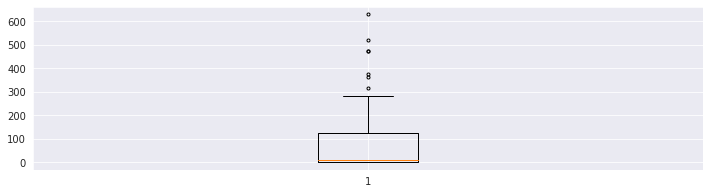

In [111]:
#  boxplot Total Last Time untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(country["Last Time"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe4fcb18d10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe5117028d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fcaaf290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fcaaf6d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fca7d790>,
  <matplotlib.lines.Line2D at 0x7fe5138be950>]}

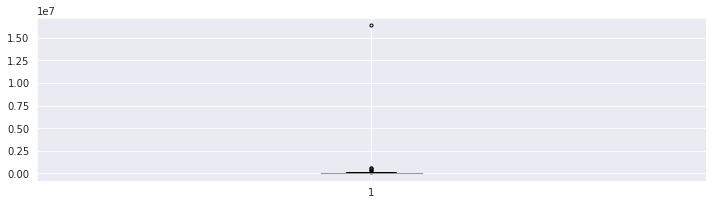

In [112]:
#  boxplot Total Frequency untuk mendeteksi outlier dengan menggunakan whiskers pada 1.5

plt.boxplot(country["Total Amount"], notch=False, sym='.', vert=True, whis=1.5,
        positions=None, widths=None, patch_artist=False,
        bootstrap=None, usermedians=None, conf_intervals=None)

## Scaling data costumer dan country
karena didalam beberapa kolom costumer dan country masih terdapat Outlier, maka data pada kolom tersebut akan di scaling untuk mengatasi outlier tersebut.

In [113]:
# menampilkan nama kolom costumer
costumer.columns

Index(['Customer ID', 'Total Amount', 'Frequency', 'Last Time'], dtype='object')

#### Remove data costumer
remove data costumer yang berada diantara Q1 dan Q3

In [114]:
# Total Amount

# hitung Quantil 1 dan 3
Q1 = costumer["Total Amount"].quantile(0.05)
Q3 = costumer["Total Amount"].quantile(0.95)
IQR = Q3 - Q1

# remove
costumer_new = costumer[(costumer["Total Amount"] >= Q1 - 1.5*IQR) & (costumer["Total Amount"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
costumer_new.shape

(5865, 4)

In [115]:
# Frequency

# hitung Quantil 1 dan 3
Q1 = costumer["Frequency"].quantile(0.05)
Q3 = costumer["Frequency"].quantile(0.95)
IQR = Q3 - Q1

# remove
costumer_new = costumer[(costumer["Frequency"] >= Q1 - 1.5*IQR) & (costumer["Frequency"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
costumer_new.shape

(5896, 4)

In [116]:
# Last Time

# hitung Quantil 1 dan 3
Q1 = costumer["Last Time"].quantile(0.05)
Q3 = costumer["Last Time"].quantile(0.95)
IQR = Q3 - Q1

# remove
costumer_new = costumer[(costumer["Last Time"] >= Q1 - 1.5*IQR) & (costumer["Last Time"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
costumer_new.shape

(5943, 4)

#### Remove data country
remove data country yang berada diantara Q1 dan Q3

In [117]:
# Total Amount

# hitung Quantil 1 dan 3
Q1 = country["Total Amount"].quantile(0.05)
Q3 = country["Total Amount"].quantile(0.95)
IQR = Q3 - Q1

# remove
country_new = country[(country["Total Amount"] >= Q1 - 1.5*IQR) & (country["Total Amount"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
country_new.shape

(42, 4)

In [118]:
# Frequency

# hitung Quantil 1 dan 3
Q1 = country["Frequency"].quantile(0.05)
Q3 = country["Frequency"].quantile(0.95)
IQR = Q3 - Q1

# remove
country_new = country[(country["Frequency"] >= Q1 - 1.5*IQR) & (country["Frequency"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
country_new.shape

(42, 4)

In [119]:
# Last Time

# hitung Quantil 1 dan 3
Q1 = country["Last Time"].quantile(0.05)
Q3 = country["Last Time"].quantile(0.95)
IQR = Q3 - Q1

# remove
country_new = country[(country["Last Time"] >= Q1 - 1.5*IQR) & (country["Last Time"] <= Q3 + 1.5*IQR)]

# ukuran costumer setelah diremove
country_new.shape

(43, 4)

#### Scaling costumer_new

In [120]:
costumer_new.columns

Index(['Customer ID', 'Total Amount', 'Frequency', 'Last Time'], dtype='object')

In [121]:
# list kolom yang akan di scaling
cos = costumer_new[['Total Amount', 'Frequency', 'Last Time']]

# scaling menggunakan standarscaler
scaler = StandardScaler()

# fit_transform
costumer_scale = scaler.fit_transform(cos)
costumer_scale.shape

(5943, 3)

####Scaling country_new

In [122]:
country_new.columns

Index(['Country', 'Frequency', 'Last Time', 'Total Amount'], dtype='object')

In [123]:
# list kolom yang akan di scaling
coun = country_new[['Frequency', 'Last Time', 'Total Amount']]

# scaling menggunakan standarscaler
scaler = StandardScaler()

# fit_transform
country_scale = scaler.fit_transform(coun)
country_scale.shape

(43, 3)

In [124]:
# buat data frame baru yang berisi data costumer_scale yang telah discaling
costumer_scale = pd.DataFrame(costumer_scale)
costumer_scale.columns = ['Amount', 'Frequency', 'Recency']
costumer_scale

,Amount,Frequency,Recency
0,-0.089614,-0.042022,0.581223
1,0.064649,0.023806,-0.948244
2,-0.033191,-0.041059,-0.603642
3,0.031382,0.000365,-0.867995
4,-0.078809,-0.051977,0.505694
...,...,...,...
5938,-0.076040,-0.048124,1.072163
5939,-0.076302,-0.053583,2.162616
5940,-0.055688,-0.034958,1.294030
5941,0.025246,-0.007342,-0.754701


In [125]:
# buat data frame baru yang berisi data country_scale yang telah discaling
country_scale = pd.DataFrame(country_scale)
country_scale.columns = ['Amount', 'Frequency', 'Recency']
country_scale

,Amount,Frequency,Recency
0,-0.155164,-0.529332,-0.114273
1,-0.161797,-0.611609,-0.172727
2,-0.167321,0.575528,-0.180977
3,-0.146932,-0.617486,-0.156323
4,-0.167947,3.090847,-0.181630
5,-0.167539,0.781220,-0.181566
6,-0.166627,0.005467,-0.180156
7,-0.156858,-0.611609,-0.165306
8,-0.160178,-0.576348,-0.172327
9,-0.167974,-0.499948,-0.181852


## MODELING Country
Metode K-Means Clustering berusaha mengelompokkan data yang ada ke dalam beberapa kelompok, dimana data dalam satu kelompok mempunyai karakteristik yang sama satu sama lainnya dan mempunyai karakteristik yang berbeda dengan data yang ada di dalam kelompok yang lain.

1. Data country akan diklasifikasikan menjadi 3 kluster dengan nilai 0,1,2
2. Evaluasi Klastering :
  * Metode Elbow, untuk melihat jumlah klustering yang optimal
  * Metode Silhouette, untuk melihat kualitas hasil klastering

#### Catatan :


*   negara dengan index klustering 0 berarti pelanggan yang berasal dari negara tersebut memiliki transaksi yang lebih tinggi dari pelanggan lain & masuk kedalam skala preoritas pertama.
*   negara dengan index klustering 1 berarti pelanggan yang berasal dari negara tersebut memiliki transaksi yang yang cukup & dapat dikatakan pelanggan tetap, serta masuk ke dalam skala preoritas kedua.
*   negara dengan index klustering 2 berarti pelanggan yang berasal dari negara tersebut memiliki transaksi yang sedikit dan masuk kedalam skala prioritas yang ketiga dalam segi bisnis kluster ini tidak terlalu penting.



In [126]:
# k-means dengan beberapa kluster
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(country_scale)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [127]:
# hasil kluster
kmeans.labels_

array([0, 0, 2, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3],
      dtype=int32)

## Evaluasi klaster

### Metode Elbow
Metode Elbow adalah metode yang digunakan untuk pemilihan jumlah cluster (k) atau kluster yang optimal, dengan melihat sum of square error (SSE).

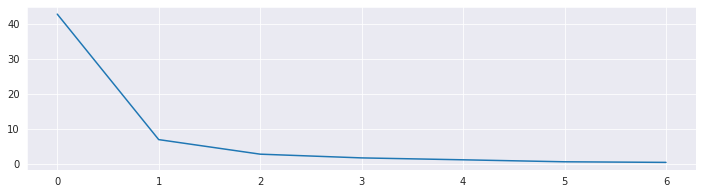

In [128]:
# Evaluasi jumlah kluster metode Elbow
ssd = []

#  banyak kluster
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# hitung sse untuk tiap n_cluster
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_scale)
    ssd.append(kmeans.inertia_)
    
# plot sse 
plt.plot(ssd)

In [129]:
# panggil ssd, untuk mnapilkan nilai SSE
ssd

[42.78201844500861,
 6.95815310081544,
 2.8029013640777434,
 1.7389499482644792,
 1.194073633196328,
 0.6274914513109329,
 0.4561250049405048]

Dapat dilihat bahwa selisi nilai dari SSE yang dihasilkan yang terbesar dalah SSE untuk k=3 yaitu (42.78201844500861-6.95815310081544)= 35.82386534419317, sehingga dapat disimpulkan jumlah kluster yang baik adalah 3 atau k=3 dengan metode Elbow

### Metode Silhouette
Metode Silhouette digunakan dengan melihat Silhouette Coefficient yang digunakan untuk melihat kualitas dan kekuatan cluster, seberapa baik suatu objek ditempatkan dalam suatu cluster. metode ini bekerja dengan cara menghitung rata-rata dari keseluruan objek (a) dan dari rata-rata keseluruhan tersebut akan diambil rata-rata yang terkecil (b).
Rumus koefisien Silhouete :
Si= (bi – ai) / max(ai, bi)



In [130]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_scale)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(country_scale, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.8765978554535713
For n_clusters=3, the silhouette score is 0.7813652642651966
For n_clusters=4, the silhouette score is 0.7667569515697086
For n_clusters=5, the silhouette score is 0.702525014236721
For n_clusters=6, the silhouette score is 0.6560468719765775
For n_clusters=7, the silhouette score is 0.6594227894559164
For n_clusters=8, the silhouette score is 0.6335682879638899


<p>Hasil klustering :</p>

1.   0.7 < (silhouette score) <= 1 Artinya : klasifikasi kuat
2.   0.5 < (silhouette score) <= 0.7 Artinya : klasifikasi medium
3.   0.25 < (silhouette score) <= 0.5 Artinya : klasifikasi lemah
4.   (silhouette score) <= 0.25     Artinya : tidak terklasifikasi

<p>Karena hasil klustering dengan menggunakan n_cluster sebanyak 3, dan dihasilkan nilai silhouette score nya yaitu 0.7813652642651966, maka dapat disimpulkan bahwa data country yang diklasifikasikan sebanyak 3 klustering kuat.</p>

### Hasil Clustering country
karena banyaknya klustering (n_clustering) yang optimal yaitu sebanyak 3 kluster dan nilai silhouette score yaitu 0.7813652642651966 dengan menggunakan n_clustering sebanyak 3 dikatakan kuat. Sehingga akan ditetapkan unuk data country akan diklasifikasikan menjadi 3 kluster.

In [131]:
# klustering ahir menggunakan 3 kluster
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(country_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [132]:
# tampilkan hasil klustering
kmeans.labels_

array([2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0],
      dtype=int32)

In [133]:
# masukan hasil klustering ke tabel country
country['Clustering'] = kmeans.labels_
country.head()

,Country,Frequency,Last Time,Total Amount,Clustering
0,Australia,1913,15,167129.07,2
1,Austria,938,1,23177.60,2
2,Bahrain,126,203,2861.55,2
3,Belgium,3123,0,63574.49,2
4,Bermuda,34,631,1253.14,0


In [134]:
# save tabel country
country.to_csv("Cluster_country.csv")

## MODELING Costumer
Metode K-Means Clustering berusaha mengelompokkan data yang ada ke dalam beberapa kelompok, dimana data dalam satu kelompok mempunyai karakteristik yang sama satu sama lainnya dan mempunyai karakteristik yang berbeda dengan data yang ada di dalam kelompok yang lain.

1. Data costumer akan diklasifikasikan menjadi 4 kluster dengan nilai 0,1,2,3
2. Evaluasi Klastering :
  * Metode Elbow, untuk melihat jumlah klustering yang optimal
  * Metode Silhouette, untuk melihat kualitas hasil klastering

#### Catatan :

*   pelanggan dengan index klustering 0 berarti pelanggan tersebut memiliki transaksi yang lebih tinggi dari pelanggan lain & masuk kedalam skala preoritas pertama.
*   pelanggan dengan index klustering 1 berarti pelanggan tersebut memiliki transaksi yang yang cukup & dapat dikatakan pelanggan tetap, serta masuk ke dalam skala preoritas kedua.
*   pelanggan dengan index klustering 2 berarti pelanggan tersebut memiliki transaksi yang sedikit dan masuk kedalam skala prioritas yang ketiga dalam segi bisnis kluster ini tidak terlalu penting.


In [135]:
# k-means dengan beberapa kluster
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(costumer_scale)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [136]:
# hasil kluster
kmeans.labels_

array([0, 1, 1, ..., 3, 1, 2], dtype=int32)

## Evaluasi klaster

### Metode Elbow
Metode Elbow adalah metode yang digunakan untuk pemilihan jumlah cluster (k) atau kluster yang optimal, dengan melihat sum of square error (SSE).

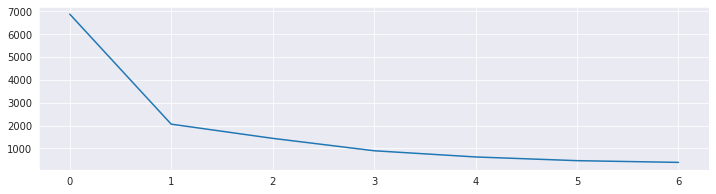

In [137]:
# Evaluasi jumlah kluster metode Elbow
ssd = []

#  banyak kluster
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# hitung sse untuk tiap n_cluster
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(costumer_scale)
    ssd.append(kmeans.inertia_)
    
# plot sse 
plt.plot(ssd)

In [138]:
# panggil ssd, untuk mnapilkan nilai SSE
ssd

[6871.6533320268445,
 2058.4308104354973,
 1437.9009482769522,
 895.387066330424,
 624.1632227952846,
 462.0136213355966,
 386.41598305879046]

Dapat dilihat bahwa selisi nilai dari SSE yang dihasilkan yang terbesar adalah SSE untuk k=3 yaitu (6871.6533320268445 - 2058.4308104354973)= 4813.222521591348, sehingga dapat disimpulkan jumlah kluster yang baik adalah 3 atau k=3 dengan metode Elbow

### Metode Silhouette
Metode Silhouette digunakan dengan melihat Silhouette Coefficient yang digunakan untuk melihat kualitas dan kekuatan cluster, seberapa baik suatu objek ditempatkan dalam suatu cluster. metode ini bekerja dengan cara menghitung rata-rata dari keseluruan objek (a) dan dari rata-rata keseluruhan tersebut akan diambil rata-rata yang terkecil (b).
Rumus koefisien Silhouete :
Si= (bi – ai) / max(ai, bi)

In [139]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(costumer_scale)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(costumer_scale, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9889231561225812
For n_clusters=3, the silhouette score is 0.700935900384759
For n_clusters=4, the silhouette score is 0.6565205267614634
For n_clusters=5, the silhouette score is 0.6634710393294979
For n_clusters=6, the silhouette score is 0.6250575803058287
For n_clusters=7, the silhouette score is 0.6309990745063234
For n_clusters=8, the silhouette score is 0.559692303966107


<p>Hasil klustering :</p>

1.   0.7 < (silhouette score) <= 1 Artinya : klasifikasi kuat
2.   0.5 < (silhouette score) <= 0.7 Artinya : klasifikasi medium
3.   0.25 < (silhouette score) <= 0.5 Artinya : klasifikasi lemah
4.   (silhouette score) <= 0.25     Artinya : tidak terklasifikasi



<p>Karena hasil klustering dengan menggunakan n_cluster sebanyak 3, dan dihasilkan nilai silhouette score nya yaitu 0.700935900384759, maka dapat disimpulkan bahwa data costumer yang diklasifikasikan sebanyak 3 klustering dapat dikatakan kuat.</p>

### Hasil Clustering country
karena banyaknya klustering (n_clustering) yang optimal yaitu sebanyak 3 kluster dan nilai silhouette score yaitu 0.700935900384759 dengan menggunakan n_clustering sebanyak 3 dikatakan kuat. Sehingga akan ditetapkan unuk data costumer akan diklasifikasikan menjadi 3 kluster.

In [140]:
# klustering ahir menggunakan 3 kluster
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(costumer_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [141]:
# tampilkan hasil klustering
kmeans.labels_

array([2, 0, 0, ..., 2, 0, 1], dtype=int32)

In [142]:
# masukan hasil klustering ke tabel country
costumer['Clustering'] = kmeans.labels_
costumer.head()

,Customer ID,Total Amount,Frequency,Last Time,Clustering
0,12346.0,-64.68,48,325,2
1,12347.0,5633.32,253,1,0
2,12348.0,2019.40,51,74,0
3,12349.0,4404.54,180,18,0
4,12350.0,334.40,17,309,2


In [143]:
# save tabel country
costumer.to_csv("Cluster_costumer.csv")

# SOLUSI 2 : Menggunakan tabel cohort

1. InvoiceMonth: Representasi string tahun dan bulan dari satu transaksi/faktur.

2. grouping : Representasi string dari tahun dan bulan pembelian pertama pelanggan. Label ini umum di semua faktur untuk pelanggan tertentu.

3. Periode kelompok / Indeks Kelompok:Sebuah bilangan bulat yang mewakili tahap pelanggan dalam "seumur hidup" -nya. Angka tersebut menunjukkan jumlah bulan yang telah berlalu sejak pembelian pertama.

In [144]:
# buat kolom baru InvoiceMont untuk merepresentasikan tahun & bulan transaksi, namum tanggal transaksinya akan dibuat diawal bulan
def get_month(x) : return dt.datetime(x.year,x.month,1)
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)


In [145]:
# tampilkan data
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Success,Unduplicated,2009,12,01,07,738,83.4,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Success,Duplicated,2009,12,01,07,738,81.0,2009-12-01


In [146]:
# kelompokan Costumer ID berdasarkan InvoiceMonth
grouping = data.groupby('Customer ID')['InvoiceMonth']

# deskripsi grouping
grouping.describe()

,count,unique,top,freq,first,last
Customer ID,,,,,,
12346.0,48,6,2010-06-01,29,2009-12-01,2011-01-01
12347.0,253,8,2010-12-01,62,2010-10-01,2011-12-01
12348.0,51,5,2010-09-01,20,2010-09-01,2011-09-01
12349.0,180,5,2011-11-01,73,2009-12-01,2011-11-01
12350.0,17,1,2011-02-01,17,2011-02-01,2011-02-01
...,...,...,...,...,...,...
18284.0,29,1,2010-10-01,29,2010-10-01,2010-10-01
18285.0,12,1,2010-02-01,12,2010-02-01,2010-02-01
18286.0,70,3,2010-08-01,50,2009-12-01,2010-08-01


In [147]:
# buat kolom baru cohortMonth yang berisi transformasi dari nilai minimum kolom InvoiceMonth 
data['CohortMonth'] = grouping.transform('min')
data.tail(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Status_invoice,desc_stockcode,year,month,day,hour,time_difference,sales,InvoiceMonth,CohortMonth
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Success,Duplicated,2011,12,09,12,0,12.60,2011-12-01,2011-08-01
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Success,Duplicated,2011,12,09,12,0,16.60,2011-12-01,2011-08-01
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Success,Unduplicated,2011,12,09,12,0,16.60,2011-12-01,2011-08-01
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,Success,Duplicated,2011,12,09,12,0,14.85,2011-12-01,2011-08-01
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,Success,Unduplicated,2011,12,09,12,0,18.00,2011-12-01,2011-08-01


In [148]:
# buat fungsi untuk mengambil data nilai tahun, bulan dan hari(tanggal) dari kolom tertentu didalam dataframe
def get_month_int (data,column):
    year = data[column].dt.year
    month = data[column].dt.month
    day = data[column].dt.day
    return year, month , day 

In [149]:
# definisikan variabel invoice_year dan invoice_month yang berisi nilai tahun dan tanggal transaksi dilakukan
invoice_year,invoice_month,_ = get_month_int(data,'InvoiceMonth')

#definisikan variabel cohort_year dan cohort_month yang berisi nilai tahun dan tanggal dari kolom CohortMonth
cohort_year,cohort_month,_ = get_month_int(data,'CohortMonth')

In [150]:
# definisikan variabel year_diff yang berisi selisi nilai antara invoice_year dan cohort_year
year_diff = invoice_year - cohort_year 

# definsikan variabel month_diff yang berisi selisi antara invoice_month dan cohort_month
month_diff = invoice_month - cohort_month 

In [151]:
# buat kolom baru yang berisi
data['CohortIndex'] = year_diff * 12 + month_diff + 1 
data['CohortIndex']

0          1
1          1
2          1
3          1
4          1
          ..
1067366    5
1067367    5
1067368    5
1067369    5
1067370    5
Name: CohortIndex, Length: 1062989, dtype: int64

In [152]:
# hitung pelanggan yang aktif tiap bulanya dari setiap kelompok
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique)

# buat tabel vivot yang indexnya berupa tiap unique didalam CohortMonth dan kolomnya berupa tiap unique didalam CohortIndex
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Customer ID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01,1046.0,393.0,359.0,448.0,411.0,409.0,409.0,375.0,356.0,393.0,453.0,519.0,388.0,306.0,268.0,320.0,274.0,317.0,304.0,288.0,275.0,333.0,320.0,428.0,219.0
2010-01-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,122.0,65.0,81.0,66.0,71.0,60.0,86.0,74.0,69.0,73.0,93.0,73.0,88.0,29.0,NaN
2010-02-01,363.0,109.0,82.0,110.0,93.0,76.0,79.0,103.0,100.0,106.0,48.0,47.0,55.0,70.0,49.0,74.0,67.0,61.0,53.0,85.0,90.0,62.0,23.0,NaN,NaN
2010-03-01,436.0,95.0,113.0,103.0,100.0,87.0,105.0,130.0,126.0,50.0,50.0,62.0,84.0,72.0,83.0,74.0,76.0,69.0,74.0,89.0,93.0,33.0,NaN,NaN,NaN
2010-04-01,291.0,67.0,58.0,47.0,54.0,67.0,79.0,76.0,33.0,34.0,24.0,42.0,40.0,47.0,46.0,43.0,41.0,41.0,50.0,61.0,19.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,49.0,45.0,49.0,48.0,66.0,56.0,33.0,17.0,22.0,31.0,35.0,38.0,41.0,27.0,33.0,36.0,42.0,40.0,12.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,269.0,58.0,53.0,55.0,62.0,76.0,35.0,25.0,22.0,32.0,28.0,38.0,42.0,35.0,30.0,33.0,37.0,55.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,183.0,38.0,37.0,52.0,55.0,28.0,21.0,28.0,26.0,22.0,25.0,29.0,25.0,26.0,37.0,32.0,45.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,158.0,39.0,50.0,51.0,29.0,21.0,16.0,22.0,23.0,21.0,22.0,20.0,27.0,32.0,29.0,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tabel Retantion Rate 
Untuk melihat seberapa banyak jumlah pelanggan lama yang tetap membeli produk, maka akan digunakan tabel retantion.

In [153]:
# ukuran tabel cohort_size
cohort_size = cohort_counts.iloc[:,0]

# hitung persentasi dari jumlah pelanggan lama yang tetap membeli produk tiap bulanya
retention = cohort_counts.divide(cohort_size,axis=0)
retention.round(3) * 100 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01,100.0,37.6,34.3,42.8,39.3,39.1,39.1,35.9,34.0,37.6,43.3,49.6,37.1,29.3,25.6,30.6,26.2,30.3,29.1,27.5,26.3,31.8,30.6,40.9,20.9
2010-01-01,100.0,21.8,30.2,30.5,27.9,29.2,26.6,23.1,28.9,34.0,31.0,16.5,20.6,16.8,18.0,15.2,21.8,18.8,17.5,18.5,23.6,18.5,22.3,7.4,NaN
2010-02-01,100.0,30.0,22.6,30.3,25.6,20.9,21.8,28.4,27.5,29.2,13.2,12.9,15.2,19.3,13.5,20.4,18.5,16.8,14.6,23.4,24.8,17.1,6.3,NaN,NaN
2010-03-01,100.0,21.8,25.9,23.6,22.9,20.0,24.1,29.8,28.9,11.5,11.5,14.2,19.3,16.5,19.0,17.0,17.4,15.8,17.0,20.4,21.3,7.6,NaN,NaN,NaN
2010-04-01,100.0,23.0,19.9,16.2,18.6,23.0,27.1,26.1,11.3,11.7,8.2,14.4,13.7,16.2,15.8,14.8,14.1,14.1,17.2,21.0,6.5,NaN,NaN,NaN,NaN
2010-05-01,100.0,19.3,17.7,19.3,18.9,26.0,22.0,13.0,6.7,8.7,12.2,13.8,15.0,16.1,10.6,13.0,14.2,16.5,15.7,4.7,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,21.6,19.7,20.4,23.0,28.3,13.0,9.3,8.2,11.9,10.4,14.1,15.6,13.0,11.2,12.3,13.8,20.4,5.9,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,20.8,20.2,28.4,30.1,15.3,11.5,15.3,14.2,12.0,13.7,15.8,13.7,14.2,20.2,17.5,24.6,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,24.7,31.6,32.3,18.4,13.3,10.1,13.9,14.6,13.3,13.9,12.7,17.1,20.3,18.4,20.3,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


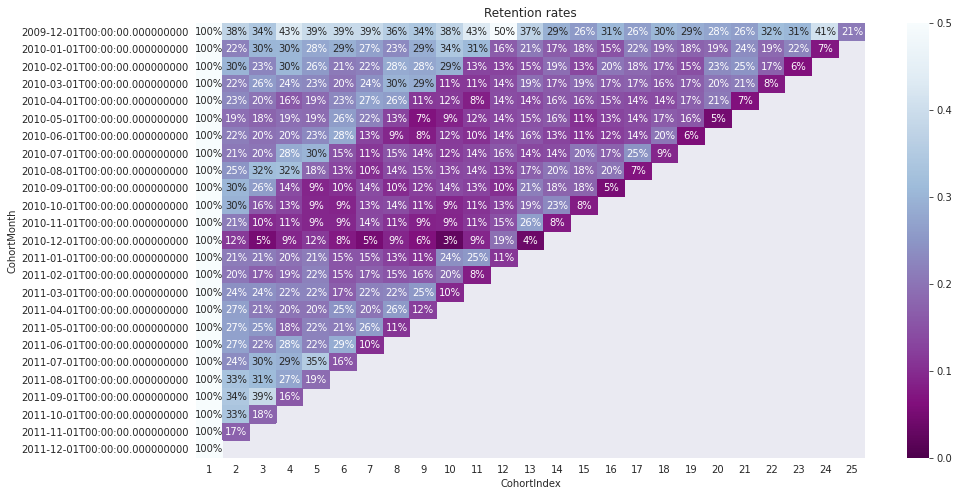

In [154]:
# buat tabel heatmap tabel retantion
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

### Jumlah pelanggan yang tetap membeli ditiap kelompok dari tiap bulanya

In [155]:
# jumlah seluruh pelanggan yang tetap membeli produk tiap kelompok di tiap bulanya
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()

# buat tabel pivot dengan indeks CohortMonth dan kolom CohortIndex, serta dengan nilai Quantity
avg_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
avg_quantity.round(1)
avg_quantity.index = avg_quantity.index.date
avg_quantity

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
2009-12-01,9.141467,13.773908,14.476812,14.095041,9.673891,9.646454,9.517351,8.565832,16.453782,7.600241,10.825200,9.069476,7.495621,7.617610,9.775015,8.346947,8.362881,9.295849,7.947412,8.133164,11.127173,10.251441,9.930503,8.369796,8.18302
2010-01-01,8.981818,12.772803,9.122480,12.536222,11.000350,11.533820,9.901275,12.059826,10.696880,12.274895,10.045257,9.152106,8.678805,8.652717,12.632245,13.025694,10.776004,10.409040,15.441018,12.486566,13.174389,13.536596,8.974758,7.215812,NaN
2010-02-01,9.680669,9.060498,15.257630,12.640979,9.650355,11.545991,11.762391,10.107898,9.227087,9.023824,9.331380,8.271245,12.039074,11.201220,8.431889,11.096986,9.266851,17.337778,9.695077,10.818220,9.257740,8.339237,11.577320,NaN,NaN
2010-03-01,9.928953,13.561131,11.532507,10.996527,10.593976,14.972189,13.792837,12.579000,10.965389,15.775057,9.591865,10.445201,13.071984,12.020810,13.266215,10.412330,13.551467,11.451928,13.515850,8.877537,12.881489,9.743542,NaN,NaN,NaN
2010-04-01,10.371736,7.992322,9.031792,14.584470,12.765138,10.656608,9.802041,8.896396,8.914027,10.132308,7.280000,13.242841,9.332207,16.320255,10.124088,12.606828,14.464607,10.960922,8.733166,9.271371,10.238267,NaN,NaN,NaN,NaN
2010-05-01,11.819219,9.562929,9.951777,12.266846,12.584932,9.146013,7.187648,5.763746,10.729167,10.916031,8.506066,11.805249,10.853720,11.272947,13.673289,11.322622,15.286713,8.996933,8.225443,7.137931,NaN,NaN,NaN,NaN,NaN
2010-06-01,9.950548,8.264493,13.020000,10.468919,10.692693,13.759615,10.879006,17.404568,31.269750,28.365706,19.442266,20.032120,22.782178,16.776333,25.752708,18.450070,12.659356,9.458263,11.991632,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,7.745206,6.666667,6.731605,8.363125,6.937856,6.601345,7.854685,9.291277,7.477184,7.042416,8.492727,11.195683,10.217252,11.758475,8.014156,8.048276,7.585317,11.281065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,7.968184,8.246225,8.540422,7.302992,10.980315,7.302752,8.154270,7.688995,12.536145,15.496920,9.070707,5.657895,9.559165,11.247277,12.887309,10.893805,12.750831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,26.367857,7.786650,7.572294,8.621873,15.635007,7.831858,13.264368,11.493204,19.234824,14.331081,15.447653,17.268882,27.671703,9.657295,13.097755,9.199346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


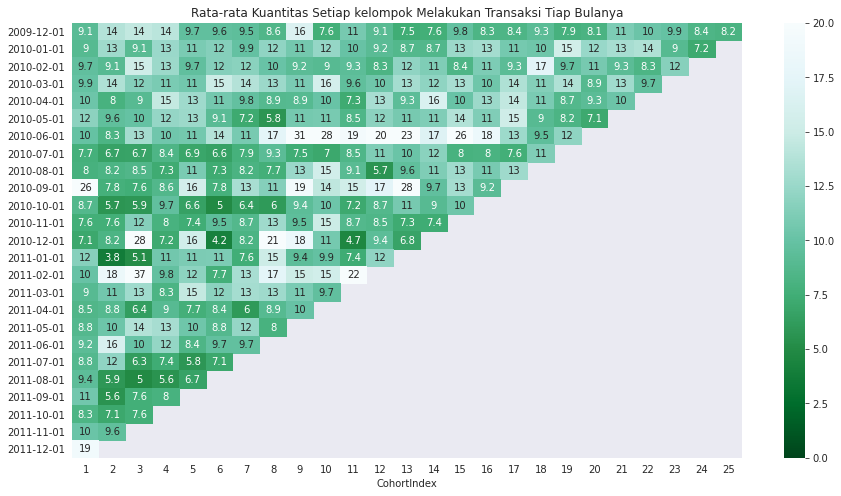

In [156]:
# buat tabel heatmap dari tabel sum_quantity
plt.figure(figsize=(15, 8))
plt.title('Rata-rata Kuantitas Setiap kelompok Melakukan Transaksi Tiap Bulanya')
sns.heatmap(data=avg_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()